In [346]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.metrics import roc_curve, auc

In [347]:
from matplotlib import rcParams
#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (8, 3)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'

C:\Users\HARSH\Anaconda3\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [348]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [349]:
data=pd.concat([train,test])

In [350]:
train.shape, test.shape

((131662, 14), (87395, 13))

In [351]:
data.shape

(219057, 14)

In [352]:
train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [353]:
train.columns

Index(['Trip_ID', 'Trip_Distance', 'Type_of_Cab', 'Customer_Since_Months',
       'Life_Style_Index', 'Confidence_Life_Style_Index', 'Destination_Type',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Gender', 'Surge_Pricing_Type'],
      dtype='object')

In [354]:
train.shape, test.shape

((131662, 14), (87395, 13))

In [2]:
# Missing Values

In [355]:
train.loc[train.Type_of_Cab.isnull(),"Type_of_Cab"]=data["Type_of_Cab"].value_counts().index[0]
train.loc[train.Confidence_Life_Style_Index.isnull(),"Confidence_Life_Style_Index"]=data["Confidence_Life_Style_Index"].value_counts().index[0]

test.loc[test.Type_of_Cab.isnull(),"Type_of_Cab"]=data["Type_of_Cab"].value_counts().index[0]
test.loc[test.Confidence_Life_Style_Index.isnull(),"Confidence_Life_Style_Index"]=data["Confidence_Life_Style_Index"].value_counts().index[0]

In [1]:
# Categorical conversion

In [357]:
Categorical = ["Type_of_Cab","Confidence_Life_Style_Index",  "Gender" ,"Destination_Type"]

In [358]:
def replacing_categorical(X):
    x=train.groupby(X)["Surge_Pricing_Type"].mean()
    y=train.groupby(X)["Surge_Pricing_Type"].std()
    train[X+str("_mean")]= train[X].apply(lambda X1: x[X1])
    train[X+str("_std")] = train[X].apply(lambda X2: y[X2])
    del train[X]
    
    test[X+str("_mean")]= test[X].apply(lambda X1: x[X1])
    test[X+str("_std")] = test[X].apply(lambda X2: y[X2])
    del test[X]

In [359]:
for i in Categorical:
    replacing_categorical(i)

In [360]:
#Preparing data
def prepare_data(df, is_train):

    if is_train:
        return df.drop(['Surge_Pricing_Type',"Trip_ID"], axis=1), df['Surge_Pricing_Type']
    return     df.drop([                     "Trip_ID"], axis=1)

In [361]:
Xtrain, Ytrain =prepare_data(train, 1)
main_train,main_test=prepare_data(train, 1)
main_data = prepare_data(test,0)

In [362]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split( Xtrain, Ytrain, stratify=Ytrain, test_size=.4)

In [363]:
Xtrain.shape,  Xtest.shape

((78997, 16), (52665, 16))

In [364]:
import xgboost

In [405]:
#from xgboost.sklearn import XGBClassifier
from xgboost import XGBClassifier

#XGBClassifier = XGBClassifier()
xgb1 = XGBClassifier(
                     learning_rate =0.5,
                     n_estimators=100,
                     max_depth=12,
                     min_child_weight=3,
                     gamma=0,
                     subsample=0.75,
                     colsample_bytree=0.9,
                     objective= 'reg:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
#parameters = {"learning_rate": [.01,.05,.1]}
#fitmodel = GridSearchCV(xgb1, param_grid=parameters, cv=5, scoring="f1")
xgb1.fit(Xtrain, ytrain)
# ##fitmodel.best_estimator_, fitmodel.grid_scores_,
#xgb1.best_params_, fitmodel.best_score_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=12,
       min_child_weight=3, missing=None, n_estimators=1000, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.75)

In [406]:
print ("Training :"+str(accuracy_score( ytrain, xgb1.predict(Xtrain))))
print ("Test :"+str(accuracy_score( ytest, xgb1.predict(Xtest))))

Training :1.0
Test :0.655444792557


In [368]:
print ("Training :"+str(accuracy_score( ytrain, xgb1.predict(Xtrain))))
print ("Test :"+str(accuracy_score( ytest, xgb1.predict(Xtest))))

Training :0.691899692393
Test :0.692813063705


In [392]:
xgb1.fit(main_train, main_test)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.4, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=100, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.75)

In [393]:
a=xgb1.predict(main_data)

In [394]:
solution = pd.DataFrame(test['Trip_ID'])
solution = pd.concat([solution, pd.DataFrame(a, columns=['Surge_Pricing_Type'])], axis=1)

In [395]:
predicted.shape, solution.shape

((87395, 1), (87395, 2))

In [396]:
path='C:\\Users\\HARSH\\Desktop\\Mini-Datahack\\Submissions\\'
solution.to_csv(path+r'2.csv', index=False)

In [397]:
solution.head(2)

,Trip_ID,Surge_Pricing_Type
0,T0005689459,1
1,T0005689462,2


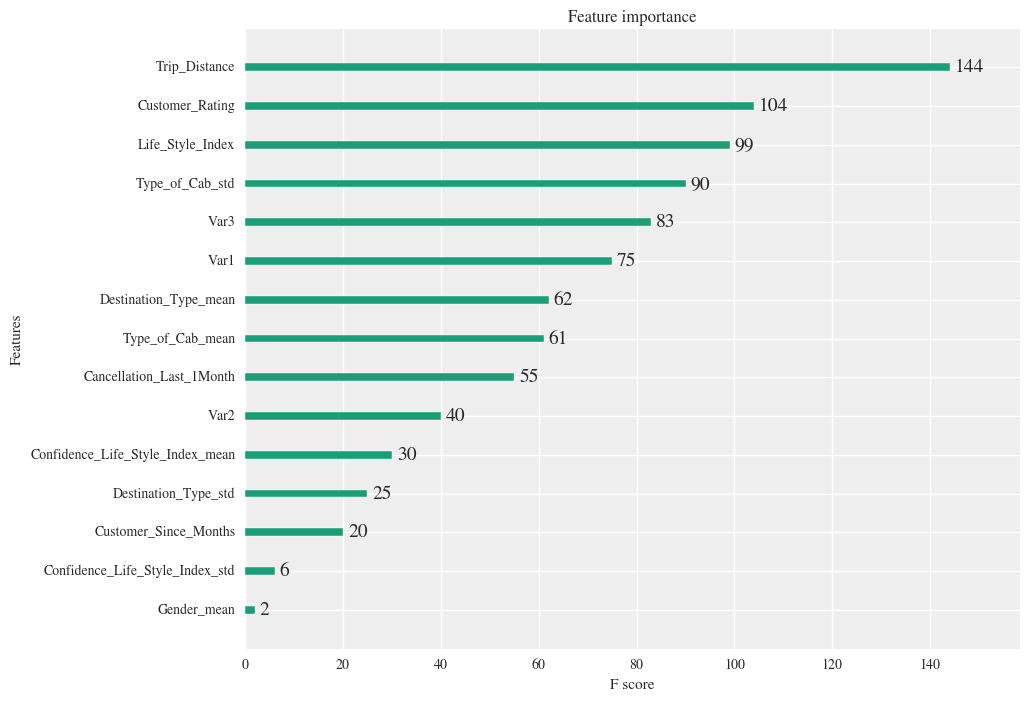

In [398]:
ax = xgboost.plot_importance(xgb1)
fig = ax.figure
fig.set_size_inches(10,8)

In [400]:
#no